<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform DEMO
Sentinel 2 data over an alpine region

In [1]:
import openeo

In [2]:
openeo.client_version()

'0.10.1'

## Connect to openEO

Via egi-checkin using the aggregator

In [3]:
openeo_aggregator = "openeo.cloud"
conn = openeo.connect(openeo_aggregator)

In [4]:
conn = conn.authenticate_oidc()

Authenticated using refresh token.


List and describe available collections

In [7]:
#conn.list_collections()

#### Using the boa_sentinel_2 collection to get an alpine region NDWI

In [8]:
from eo_utils import openeoMap
center = [47, 12.84]
zoom = 11

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[47, 12.84], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [9]:
from openeo.util import to_bbox_dict
bbox = eoMap.getBbox()
spatial_extent = to_bbox_dict(bbox) 
print(spatial_extent)

{'west': 12.765132, 'south': 46.988715, 'east': 12.894492, 'north': 47.043255}


Looking at changes over one year - Temporal Downsampling

<img src="https://openeo.org/assets/img/dc_resample_time.987e797c.png"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;"
     width="600" />

In [10]:
collection      = 'boa_sentinel_2'

temporal_extent = ["2019-01-01", "2019-12-31"] 
bands           = ["B02", "B03", "B04", "B08"] 

data = conn.load_collection(collection, spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

In [14]:
data_agg = data.aggregate_temporal_period(reducer="mean", period="month", dimension="t")

data_agg_ndwi = data_agg.apply(lambda x: x.clip(min=0, max=6000).ndvi(nir="B08", red="B03"))

In [15]:
data_agg_ndwi_saved = data_agg_ndwi.save_result(format="NetCDF")

In [16]:
job = data_agg_ndwi_saved.create_job(title = "BOA_S2_alpine_region")
print(f"Batch job with id {job.job_id} has status  {job.status()}")

Batch job with id eodc-jb-7adea1b8-4161-413b-84c1-8e2a215401c3 has status  created


In [17]:
job.start_job()
print(f"Batch job with id {job.job_id} has status  {job.status()}")

Batch job with id eodc-jb-7adea1b8-4161-413b-84c1-8e2a215401c3 has status  running


In [23]:
job

<RESTJob job_id='jb-4ce1a4dd-cab0-4695-a43f-af99cf3e918a'>

In [24]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./demo_data/")

[PosixPath('demo_data/out_2022_05_19T10_04_25_EU010M_E049N015T1.nc'),
 PosixPath('demo_data/out_2022_05_19T10_04_25_EU010M_E050N015T1.nc'),
 PosixPath('demo_data/job-results.json')]

In [42]:
import numpy as np
import xarray as xr
output_data5 = xr.open_dataset("./demo_data/out_2022_05_19T10_04_25_EU010M_E049N015T1.nc")
output_data5 = output_data5.where(output_data5!=-9999, np.nan)

In [43]:
output_data5

<xarray.Dataset>
Dimensions:      (month: 12, y: 2740, x: 3347)
Coordinates:
  * y            (y) float64 1.532e+06 1.532e+06 ... 1.505e+06 1.505e+06
  * x            (x) float64 4.967e+06 4.967e+06 4.967e+06 ... 5e+06 5e+06 5e+06
    spatial_ref  int32 0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    t            datetime64[ns] 2022-05-19T10:04:25.586518
Data variables:
    result       (month, y, x) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
Attributes:
    crs:                PROJCRS["Azimuthal_Equidistant",BASEGEOGCRS["WGS 84",...
    datetime_from_dim:  2022-05-19 10:04:25.589916

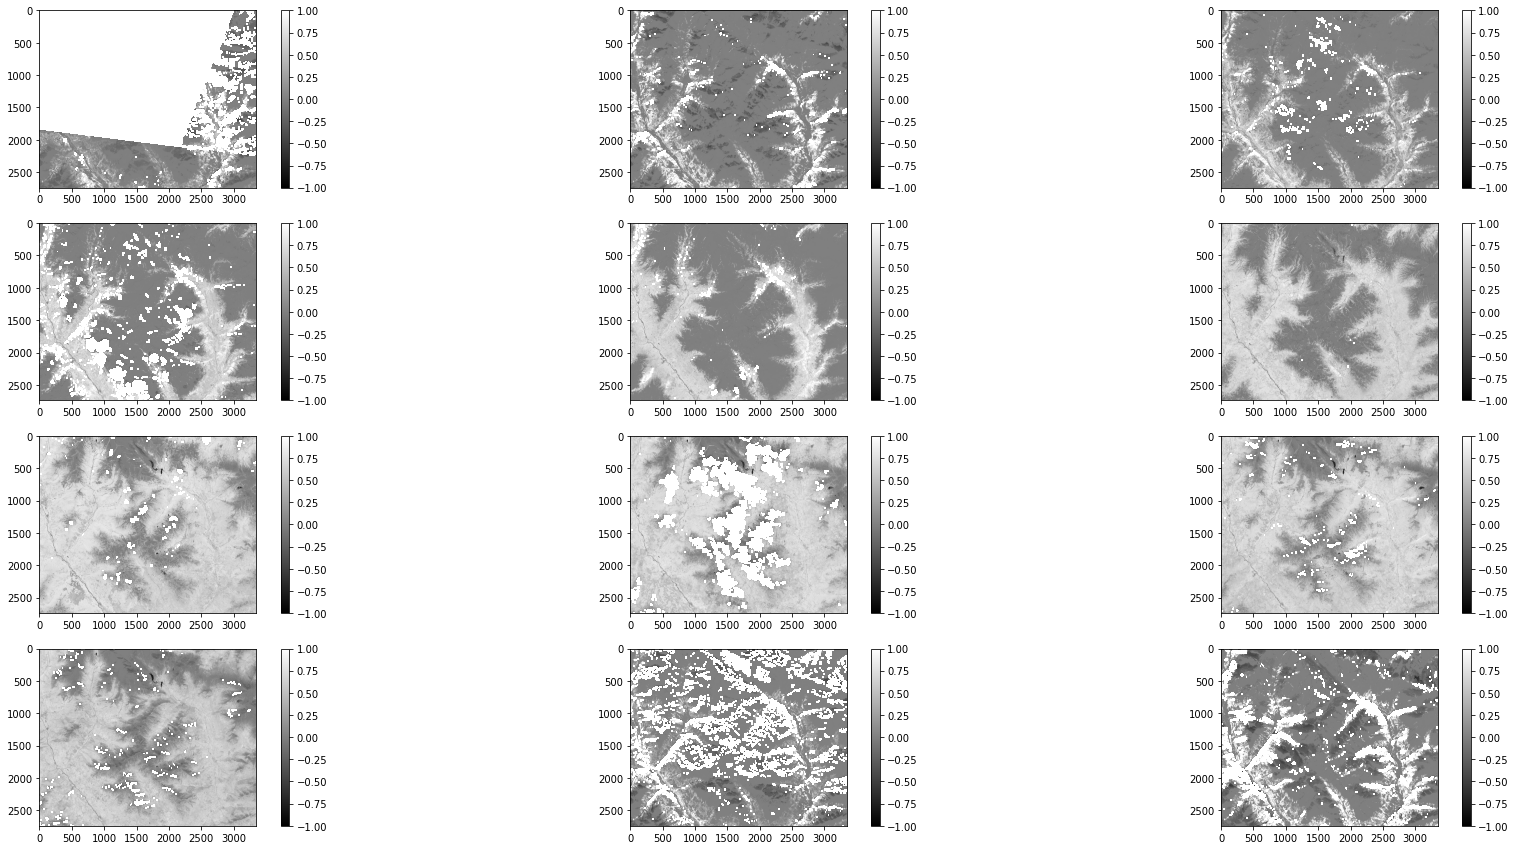

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))

for i in range(1,13):
    month = output_data5.result.sel(month=i)
    plt.subplot(4,3,i)
    plt.imshow(month, cmap = "gray", vmin=-1, vmax=1)   
    plt.colorbar()